In [ ]:
%%capture
"""
-----------------------------------------------------------------------------------------------------------------------------------------------------------
This file is used to compute fit a pair of coupled 1D sinusoidal ODEs. It does so using a MSE loss and whole batch methods.
It calculated the Hessian during this process using the library-function approach.
Hessian calculations via the "manual" approach and the MOFD were considered too lengthy to be part of the same file, and can instead be found in the file
mse_hessians_sinusoidal.ipynb.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
"""

In [ ]:
%%capture
%%bash 
pip install torchdiffeq

In [ ]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=20)
parser.add_argument('--niters', type=int, default=100)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
parser.add_argument('--manual_hessian', action='store_true')
parser.add_argument('--library_hessian', action='store_true')
parser.add_argument('--hessian_freq', type=int, default=20)
args = parser.parse_args(args=[])

args.niters = 1500
args.test_freq = 20
args.library_hessian = False
args.manual_hessian = False
args.viz = True
args.hessian_freq = 100
args.method = 'dopri5'
args.data_size = 50

In [ ]:
#The technique only works when the adjoint method is not used. If it is used, the Hessian returned is a matrix of zeros.
adjoint = False

if adjoint == True:
    from torchdiffeq import odeint_adjoint as odeint
if adjoint == False:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

true_y0 = torch.tensor([[2., 1.]]).to(device)
t = torch.linspace(0., 7., args.data_size).to(device)
f = 1.0
true_A = torch.tensor([[0.0, f], [-f, -0.0]]).to(device)

class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y, true_A)

#The true solution defines two sinusoidal curves.
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method = args.method)

In [ ]:
%%capture
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
if args.viz:
    makedirs('png')
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')    

In [ ]:
def visualize(true_y, pred_y, odefunc, itr):

  """
  This slightly altered version of the function visualize() seems to work fine. The only change is that I have moved the plt.figure() part of the code
  inside the function itself, i.e. I am creating a new figure environment for every figure, instead of editing the same environment multiple times.
  """

  if args.viz:

    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)        
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)

    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    ax_traj.set_ylim(-2.5, 2.5)

    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(-2.5, 2.5)
    ax_phase.set_ylim(-2.5, 2.5)

    ax_vecfield.set_title('Learned Vector Field')
    ax_vecfield.set_xlabel('x')
    ax_vecfield.set_ylabel('y')

    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlim(-2, 2)
    ax_vecfield.set_ylim(-2, 2)

    fig.tight_layout()
    plt.savefig('png/{:03d}'.format(itr))
    plt.draw()
    plt.pause(0.001)
    plt.close()

In [ ]:
class ODEFunc(nn.Module):
    """
    Defines a very simple neural net.
    """

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 20),
            nn.Softplus(),
            nn.Linear(20, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [ ]:
class Network(nn.Module):
  """
  Neural network that is used for Hessian calculation with library-function and MOFD approaches.
  The parameter groups are chosen to match those of ODEFunc().
  """

  def __init__(self, a, b, c, d):
    super(Network, self).__init__()
    self.a = a
    self.b = b
    self.c = c
    self.d = d

  def forward(self, t, y):
    x = F.linear(y, self.a, self.b)
    m = nn.Tanh()
    x = m(x)
    x = F.linear(x, self.c, self.d)
    return x

In [ ]:
def get_loss(params_vector):

  a = params_vector[:16].reshape([8, 2])
  b = params_vector[16:24].reshape([8])
  c = params_vector[24:40].reshape([2, 8])
  d = params_vector[40:42].reshape([2])
  
  neural_net = Network(a, b, c, d).to(device)
  pred_y = odeint(neural_net, true_y0, t, method= args.method)
  loss_func = nn.MSELoss()
  loss = loss_func(pred_y, true_y)
  return loss

def get_library_hessian(net):
  """
  Obtains the Hessian of the NODE using the autograd.functional.hessian() function.
  Inputs: 
        - net: the network for which the Hessian is to be calculated.
  NB: Each individual NODE architecture must be specified in the function get_loss(), such that
  the Hessian is calculated correctly.
  """

  param_tensors = net.parameters()
  params_vector = torch.tensor([]).to(device)
  for param in param_tensors:
    vec = torch.reshape(param, (-1,)).to(device)
    params_vector = torch.cat((params_vector, vec))

  hessian = torch.autograd.functional.hessian(get_loss, params_vector)
  return hessian

Iter 0001 | Total Loss 3.270591


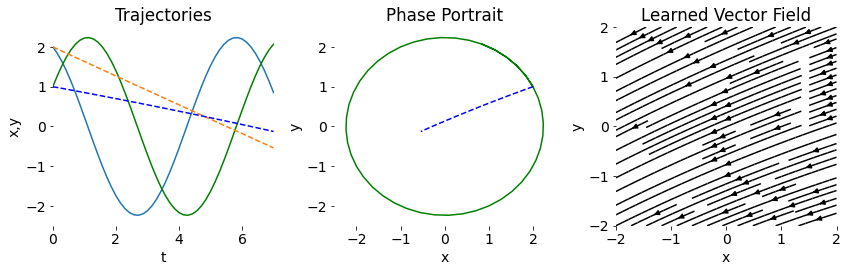

Saving for iteration no. 1
Iteration: 19Iter 0020 | Total Loss 3.028324


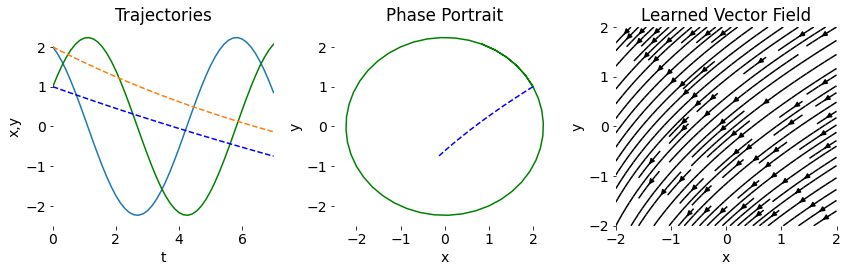

Saving for iteration no. 20
Iteration: 39Iter 0040 | Total Loss 2.867366


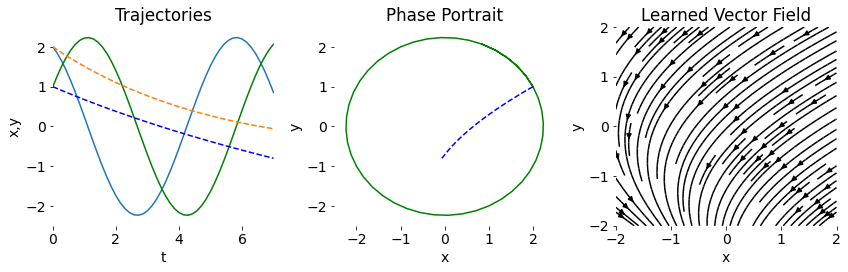

Saving for iteration no. 40
Iteration: 59Iter 0060 | Total Loss 2.686593


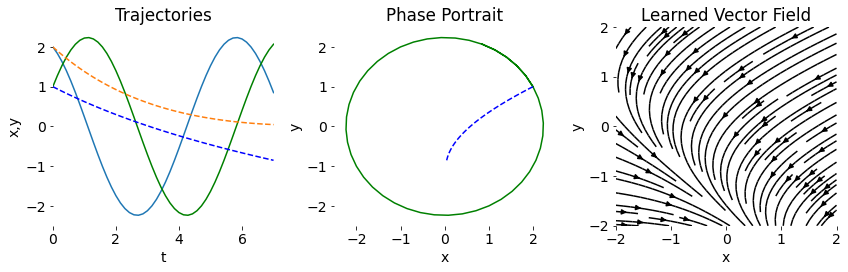

Saving for iteration no. 60
Iteration: 79Iter 0080 | Total Loss 2.509921


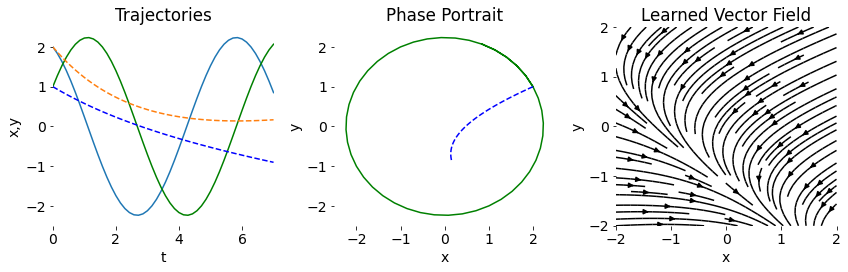

Saving for iteration no. 80
Iteration: 99Iter 0100 | Total Loss 2.353357


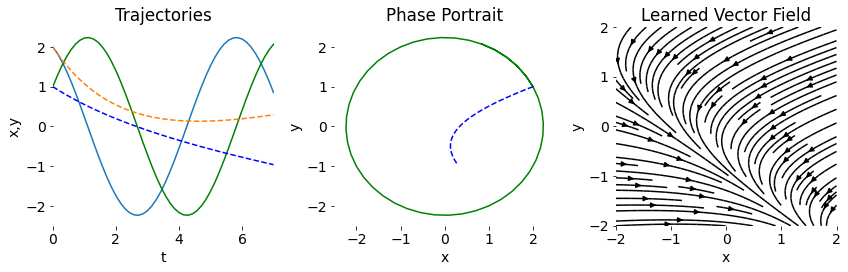

Saving for iteration no. 100
Iteration: 119Iter 0120 | Total Loss 2.219869


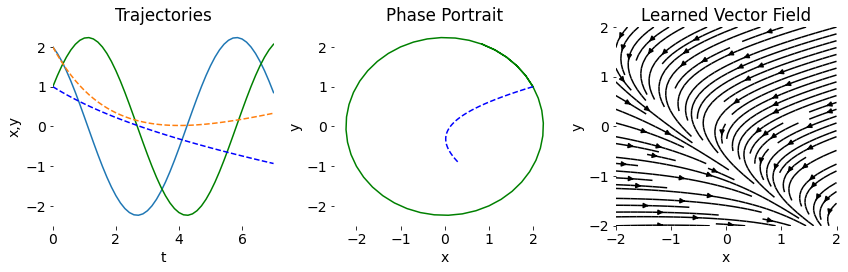

Saving for iteration no. 120
Iteration: 139Iter 0140 | Total Loss 2.097440


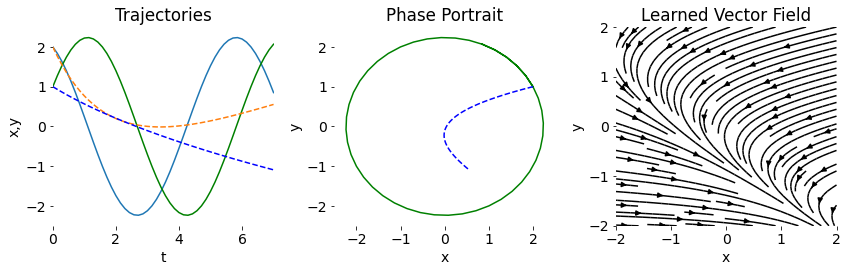

Saving for iteration no. 140
Iteration: 159Iter 0160 | Total Loss 1.982792


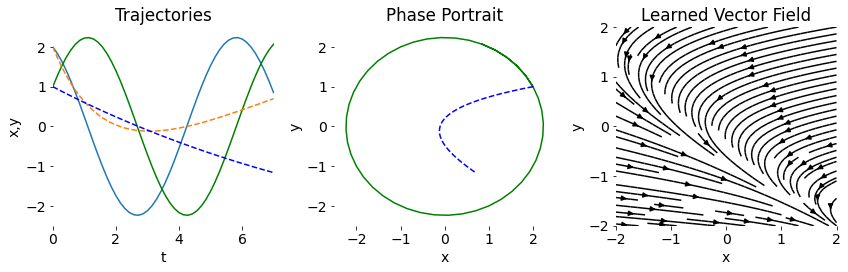

Saving for iteration no. 160
Iteration: 179Iter 0180 | Total Loss 1.864062


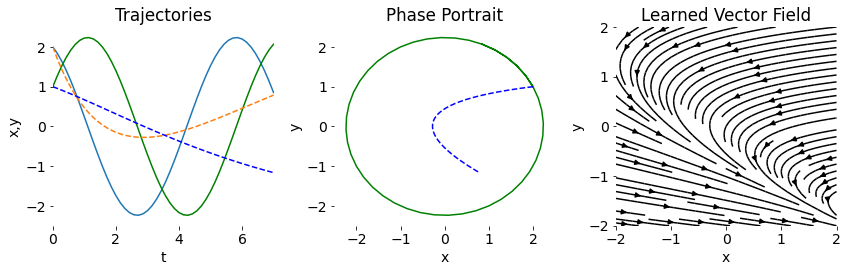

Saving for iteration no. 180
Iteration: 199Iter 0200 | Total Loss 1.729322


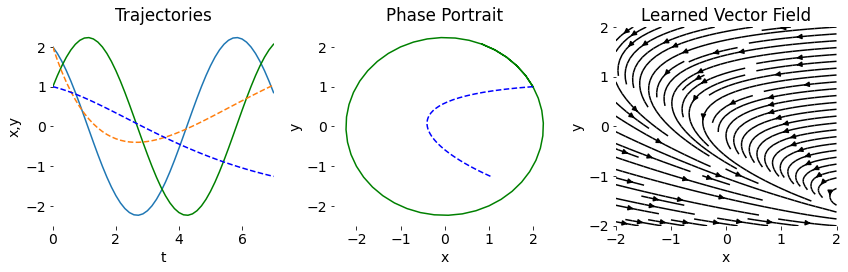

Saving for iteration no. 200
Iteration: 219Iter 0220 | Total Loss 1.561190


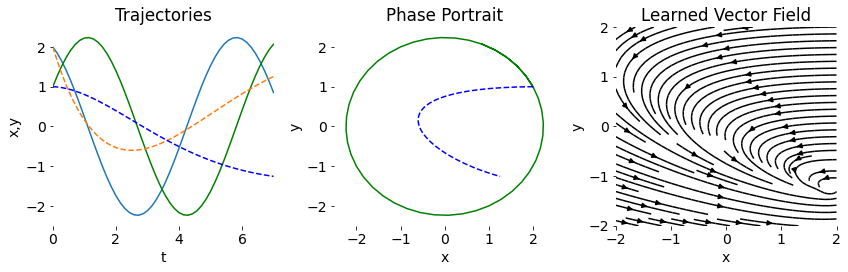

Saving for iteration no. 220
Iteration: 239Iter 0240 | Total Loss 1.321549


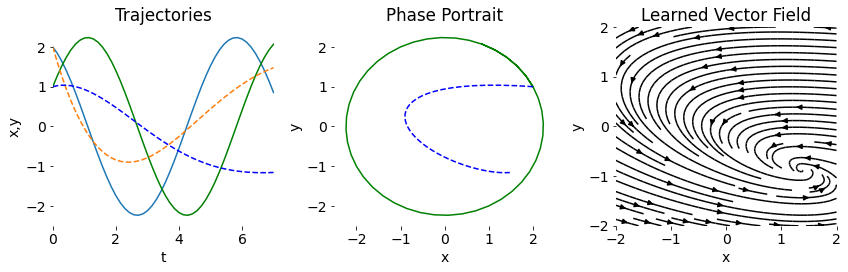

Saving for iteration no. 240
Iteration: 259Iter 0260 | Total Loss 0.955835


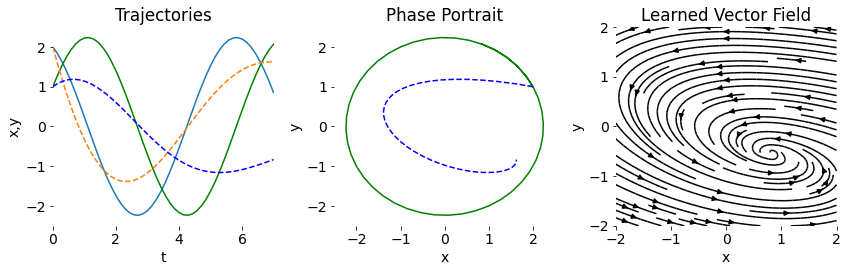

Saving for iteration no. 260
Iteration: 279Iter 0280 | Total Loss 0.484942


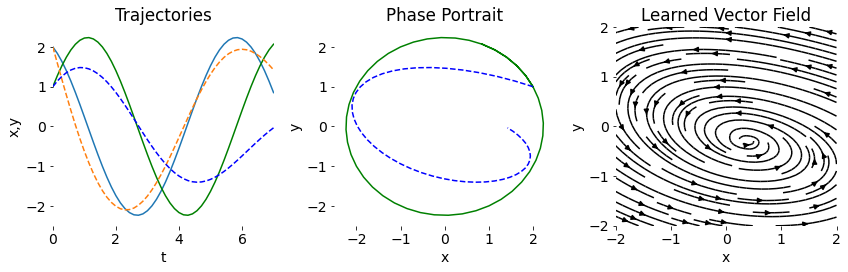

Saving for iteration no. 280
Iteration: 299Iter 0300 | Total Loss 0.235481


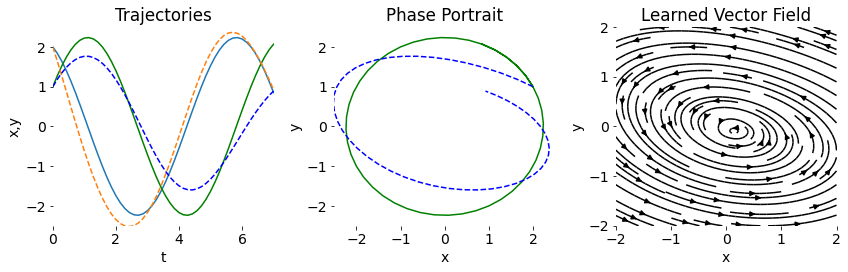

Saving for iteration no. 300
Iteration: 319Iter 0320 | Total Loss 0.163081


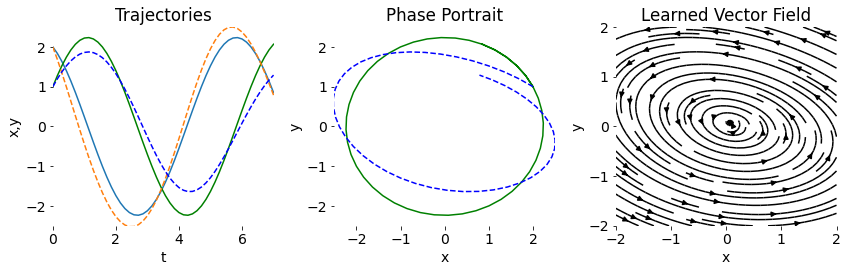

Saving for iteration no. 320
Iteration: 339Iter 0340 | Total Loss 0.121872


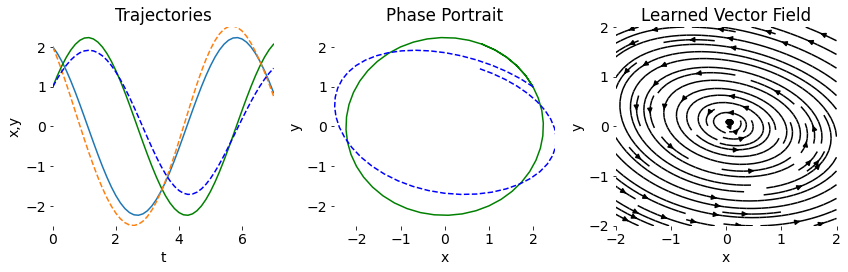

Saving for iteration no. 340
Iteration: 359Iter 0360 | Total Loss 0.089862


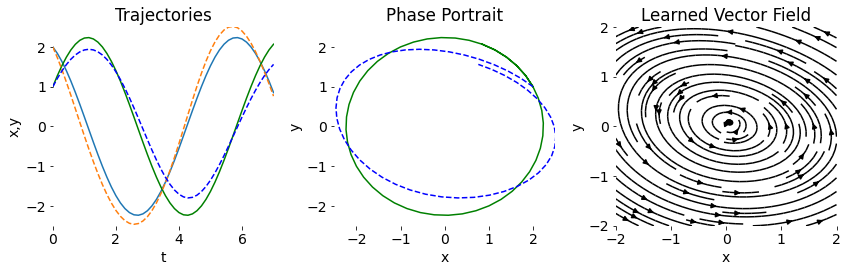

Saving for iteration no. 360
Iteration: 379Iter 0380 | Total Loss 0.064547


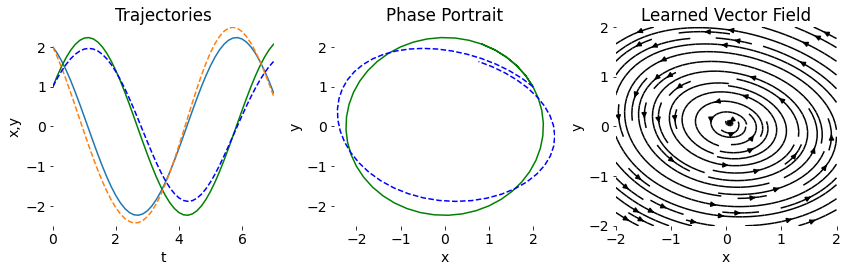

Saving for iteration no. 380
Iteration: 399Iter 0400 | Total Loss 0.045155


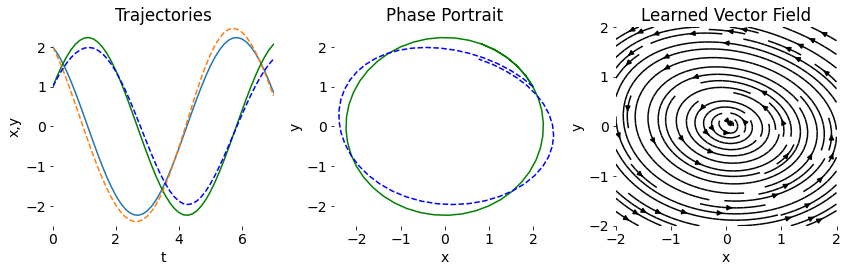

Saving for iteration no. 400
Iteration: 419Iter 0420 | Total Loss 0.030853


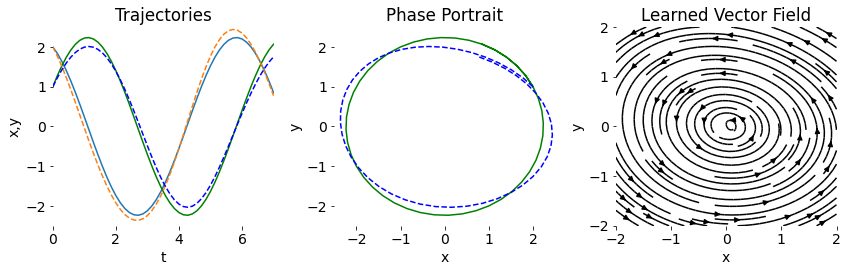

Saving for iteration no. 420
Iteration: 439Iter 0440 | Total Loss 0.020719


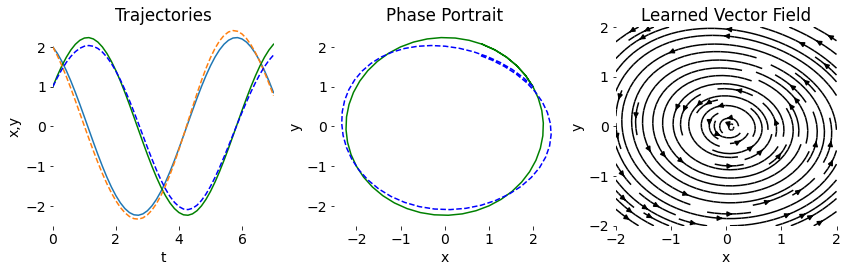

Saving for iteration no. 440
Iteration: 459Iter 0460 | Total Loss 0.013824


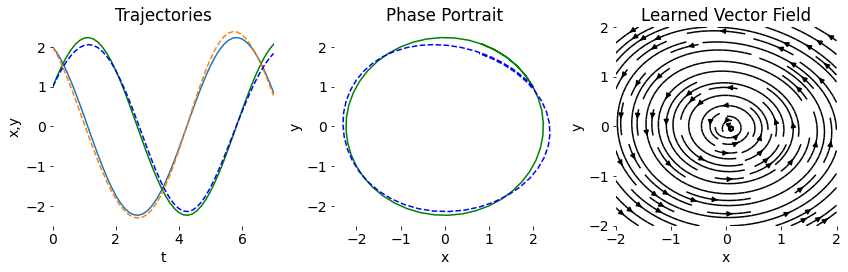

Saving for iteration no. 460
Iteration: 479Iter 0480 | Total Loss 0.009314


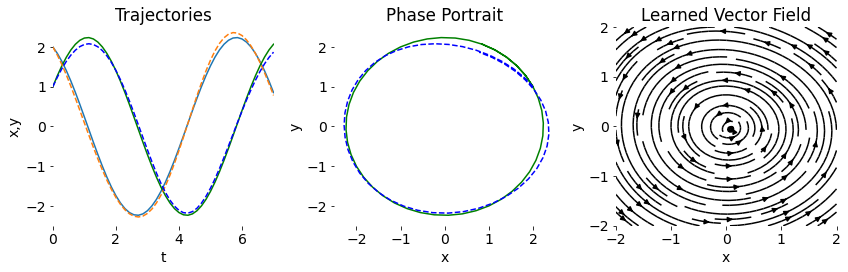

Saving for iteration no. 480
Iteration: 499Iter 0500 | Total Loss 0.006469


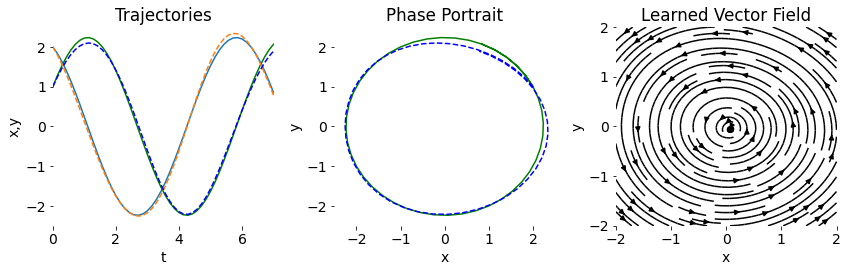

Saving for iteration no. 500
Iteration: 519Iter 0520 | Total Loss 0.004721


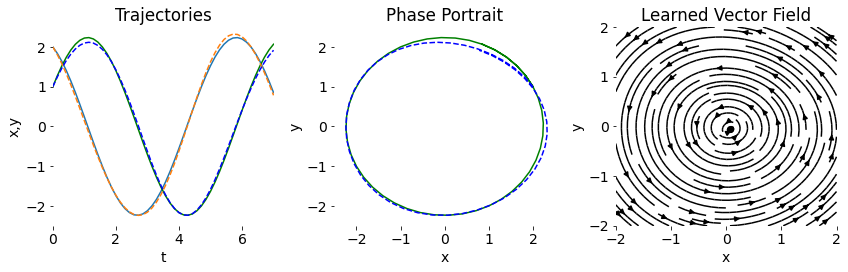

Saving for iteration no. 520
Iteration: 539Iter 0540 | Total Loss 0.003654


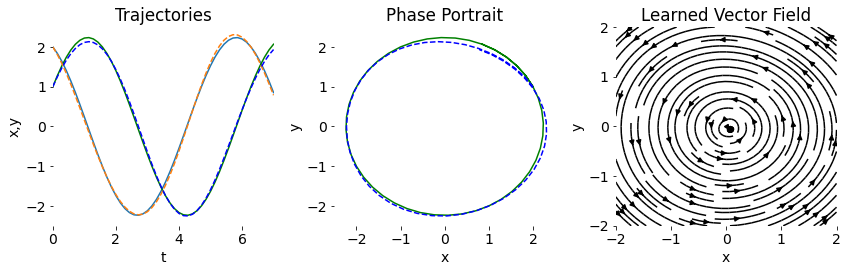

Saving for iteration no. 540
Iteration: 559Iter 0560 | Total Loss 0.002985


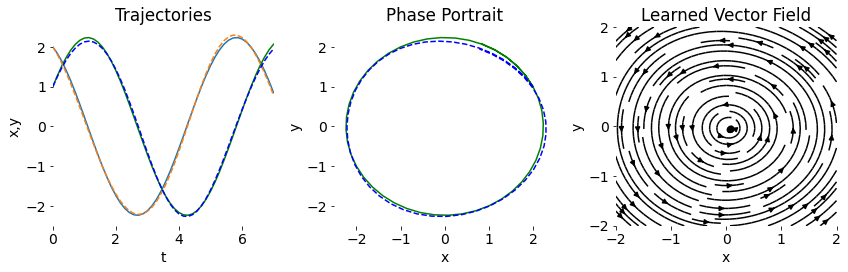

Saving for iteration no. 560
Iteration: 579Iter 0580 | Total Loss 0.003619


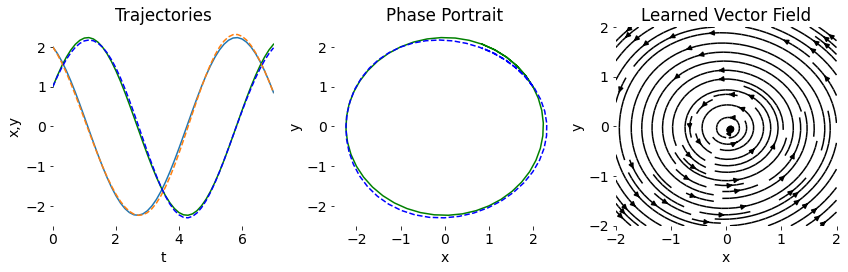

Saving for iteration no. 580
Iteration: 599Iter 0600 | Total Loss 0.002312


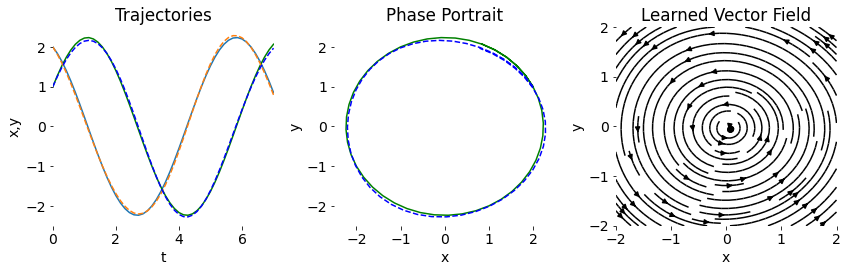

Saving for iteration no. 600
Iteration: 619Iter 0620 | Total Loss 0.002101


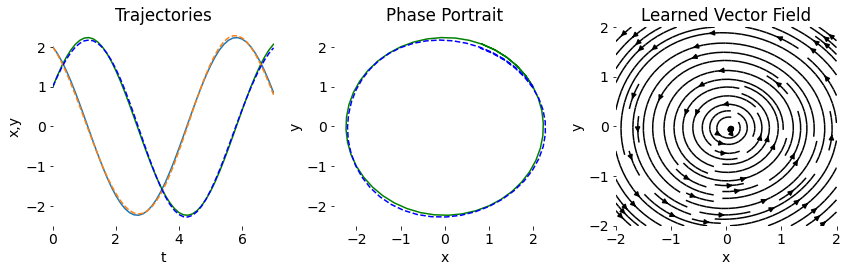

Saving for iteration no. 620
Iteration: 635

In [ ]:
if __name__ == '__main__':
    """
    Executes the programme. This includes doing the following:

      - Trains the network;
      - Outputs the results in a series of png files (if desired);
      - Outputs hessian matrix information in list form.
    """

    ii = 0

    func = ODEFunc().to(device)
    
    optimizer = optim.RMSprop(func.parameters(), lr=1e-3) 
    loss_data = []

    loss_func = nn.MSELoss()

    for itr in range(1, args.niters + 1):
  
        optimizer.zero_grad()                                 
                    
        pred_y = odeint(func, true_y0, t, method = args.method)
        loss = loss_func(pred_y, true_y)     

        loss.backward(create_graph=False) 
      
        
        if itr % args.hessian_freq == 0 or itr==1:
          if args.library_hessian:
            print('\nObtaining library hessian...')
            library_start = time.time()
            library_hessian = get_library_hessian(func)                       #get hessian with library functions   
            library_end = time.time()
            print("Time taken for library-based approach was " + str(round(library_end-library_start,2)) + "s.")
            library_hessian_data.append((itr, library_end-library_start, loss.item(), library_hessian))
      

        if itr % args.test_freq == 0 or itr == 1:
          ii += 1       
          with torch.no_grad():
              loss_data.append((itr, loss.item()))
              print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
              visualize(true_y, pred_y, func, ii)
              print("Saving for iteration no. " + str(itr))
              torch.save(func,  '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
                                + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
                                + '/20_dims/models/model_' + str(itr) + '.pt')       

        optimizer.step()                                                                   
        print('\rIteration: ' + str(itr), end = '')

In [ ]:
torch.save(loss_data, '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
                      + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
                      + '/20_dims/loss_data.pt')

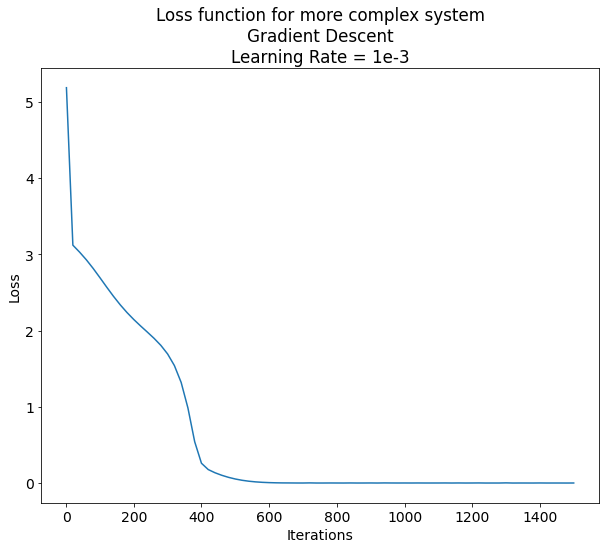

In [ ]:
#Create a plot of the loss curve.
itrs = []
data = []

for item in loss_data:
  itrs.append(item[0])
  data.append(item[1])

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 14})
plt.plot(itrs, data)
plt.title('Loss function\nGradient Descent'
          + '\nLearning Rate = 1e-3' )
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig('/content/drive/MyDrive/colab_notebooks/NODE_Hessian/calculating_hessians'
            + '/testing_on_simple_nodes/sinusoidal_curve/mse_loss'
            + '/20_dims/loss_curve.png')
plt.show()